<a href="https://colab.research.google.com/github/billumillu/Object-Detection-FasterRCNN/blob/main/Object_Detection_%7C_FasterRCNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!pip install nteract-scrapbook
!pip install cytoolz

In [7]:
# Add later - code to dwnld utils_cv directly from GDrive.

In [8]:
import sys

sys.path.append("../../")

import os
import time
import matplotlib.pyplot as plt
from typing import Iterator
from pathlib import Path
from PIL import Image
from random import randrange
from typing import Tuple
import torch
import torchvision
from torchvision import transforms
import scrapbook as sb

from utils_cv.classification.data import Urls as UrlsIC
from utils_cv.common.data import unzip_url, data_path
from utils_cv.detection.data import Urls
from utils_cv.detection.dataset import DetectionDataset, get_transform
from utils_cv.detection.plot import (
    plot_grid,
    plot_boxes,
    plot_pr_curves,
    PlotSettings,
    plot_counts_curves,
    plot_detections
)
from utils_cv.detection.model import (
    DetectionLearner,
    get_pretrained_fasterrcnn,
)
from utils_cv.common.gpu import which_processor, is_windows

# Change matplotlib backend so that plots are shown for windows
if is_windows():
    plt.switch_backend("TkAgg")

print(f"TorchVision: {torchvision.__version__}")
which_processor()

TorchVision: 0.7.0+cu101
Torch is using GPU: Tesla K80


In [9]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

DATA_PATH = unzip_url(Urls.fridge_objects_path, exist_ok=True)
NEG_DATA_PATH = unzip_url(UrlsIC.fridge_objects_negatives_path, exist_ok=True)
EPOCHS = 10
LEARNING_RATE = 0.005
IM_SIZE = 500
SAVE_MODEL = True

# train on the GPU or on the CPU, if a GPU is not available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f"Using torch device: {device}")

Using torch device: cuda


In this notebook, we use a toy dataset called Fridge Objects, which consists of 134 images of 4 classes of beverage container {can, carton, milk bottle, water bottle} photos taken on different backgrounds. The helper function downloads and unzips data set to the ComputerVision/data directory.

Set that directory in the path variable for ease of use throughout the notebook.

In [10]:
path = Path(DATA_PATH)
os.listdir(path)

['images', 'annotations', '.DS_Store']

In [11]:
data = DetectionDataset(DATA_PATH, train_pct=0.75)

In [12]:
print(
    f"Training dataset: {len(data.train_ds)} | Training DataLoader: {data.train_dl} \
    \nTesting dataset: {len(data.test_ds)} | Testing DataLoader: {data.test_dl}"
)

Training dataset: 96 | Training DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f33a4c8a828>     
Testing dataset: 32 | Testing DataLoader: <torch.utils.data.dataloader.DataLoader object at 0x7f337fac1be0>


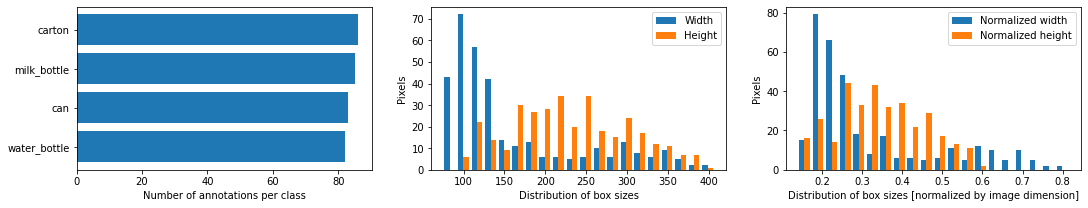

In [13]:
data.plot_boxes_stats()

Transformations applied on /content/data/odFridgeObjects/images/128.jpg:


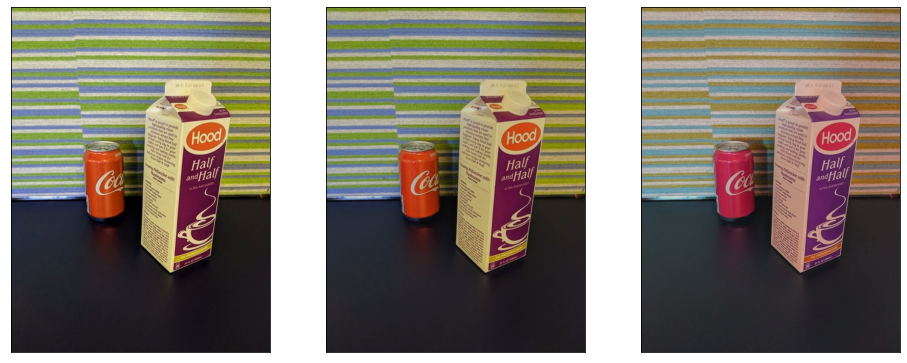

In [14]:
data.train_ds.dataset.show_im_transformations()

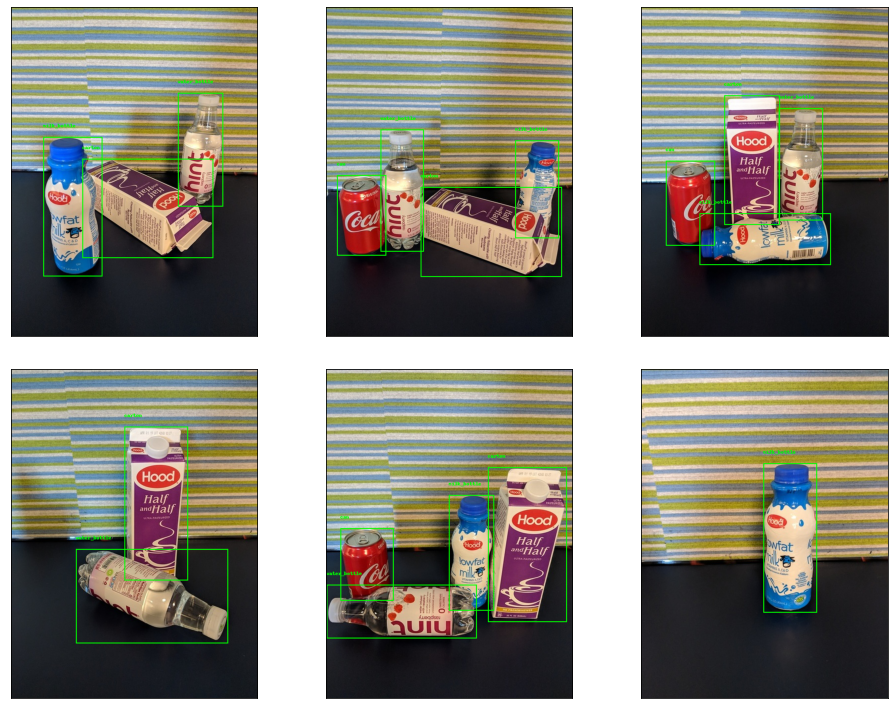

In [15]:
data.show_ims(rows=2)

In [16]:
detector = DetectionLearner(data, im_size=IM_SIZE)
print(f"Model: {type(detector.model)}")

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth



Model: <class 'torchvision.models.detection.faster_rcnn.FasterRCNN'>


In [17]:
skip_evaluation = device.type == 'cpu'

In [18]:
detector.fit(EPOCHS, lr=LEARNING_RATE, print_freq=30, skip_evaluation=skip_evaluation)

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


Epoch: [0]  [ 0/48]  eta: 0:04:07  lr: 0.000111  loss: 2.1863 (2.1863)  loss_classifier: 1.8403 (1.8403)  loss_box_reg: 0.3342 (0.3342)  loss_objectness: 0.0081 (0.0081)  loss_rpn_box_reg: 0.0036 (0.0036)  time: 5.1509  data: 2.2476  max mem: 663
Epoch: [0]  [30/48]  eta: 0:00:10  lr: 0.003300  loss: 0.5935 (0.9147)  loss_classifier: 0.2532 (0.5508)  loss_box_reg: 0.3119 (0.3558)  loss_objectness: 0.0042 (0.0057)  loss_rpn_box_reg: 0.0016 (0.0024)  time: 0.4369  data: 0.0001  max mem: 972
Epoch: [0]  [47/48]  eta: 0:00:00  lr: 0.005000  loss: 0.5588 (0.7889)  loss_classifier: 0.2284 (0.4341)  loss_box_reg: 0.3260 (0.3480)  loss_objectness: 0.0013 (0.0044)  loss_rpn_box_reg: 0.0018 (0.0024)  time: 0.4354  data: 0.0001  max mem: 972
Epoch: [0] Total time: 0:00:25 (0.5409 s / it)
creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.3542 (0.3542)  evaluator_time: 0.0154 (0.0154)  time: 1.0920  data: 0.7202  max mem: 972
Test:  [15/16]  eta: 0:00:00  model_time: 0.20

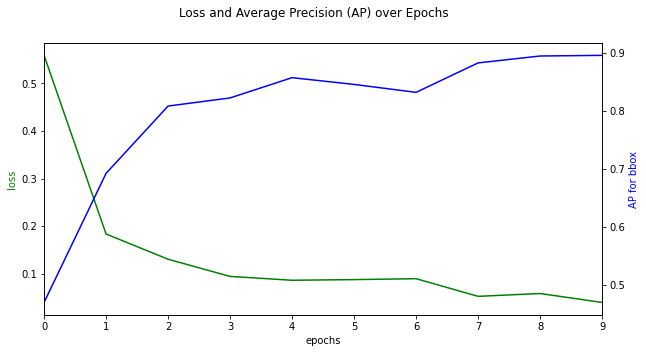

In [19]:

if not skip_evaluation:
    detector.plot_precision_loss_curves()

In [20]:
if not skip_evaluation:
    e = detector.evaluate()

creating index...
index created!
Test:  [ 0/16]  eta: 0:00:17  model_time: 0.3394 (0.3394)  evaluator_time: 0.0097 (0.0097)  time: 1.0776  data: 0.7265  max mem: 972
Test:  [15/16]  eta: 0:00:00  model_time: 0.1997 (0.2085)  evaluator_time: 0.0039 (0.0044)  time: 0.2598  data: 0.0455  max mem: 972
Test: Total time: 0:00:04 (0.2745 s / it)
Averaged stats: model_time: 0.1997 (0.2085)  evaluator_time: 0.0039 (0.0044)
Accumulating evaluation results...
DONE (t=0.03s).
IoU metric: bbox
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.896
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.999
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.985
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = -1.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.896
 Average Recall     (AR) @[ IoU=

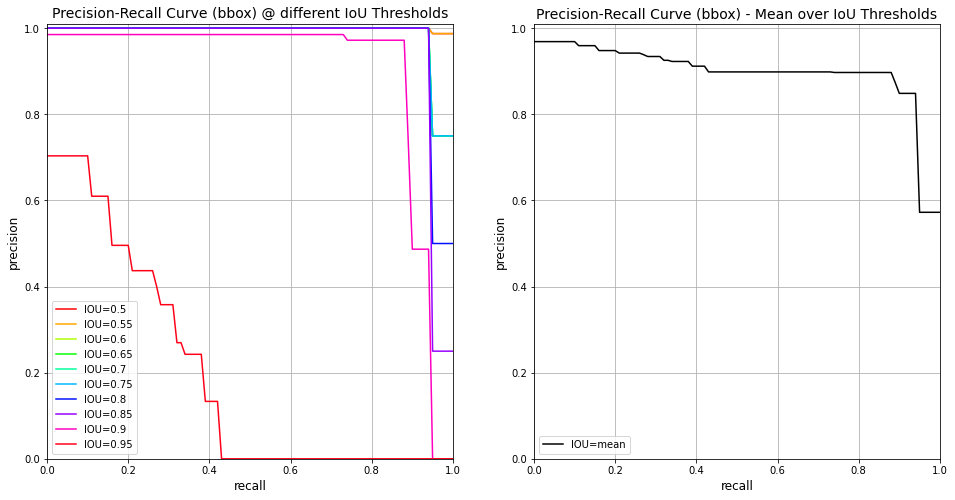

In [21]:
if not skip_evaluation:
    plot_pr_curves(e)

Running detector on 32 test images...
Running detector on 64 negative images...


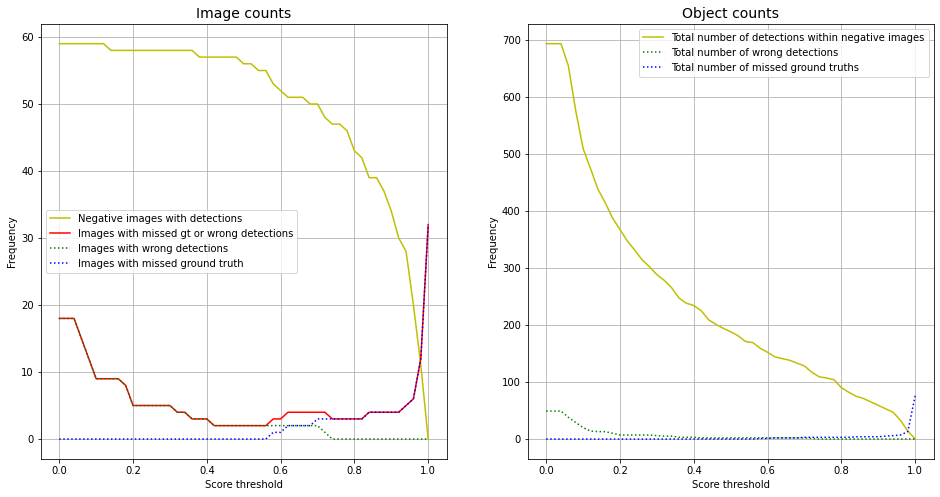

In [22]:
# Run detector on the test images. Set threshold to 0 to keep all low confidence detections.
print(f"Running detector on {len(data.test_ds)} test images...")
detections = detector.predict_dl(data.test_dl, threshold=0)

# Run detector on the negative images
if NEG_DATA_PATH is None or NEG_DATA_PATH == "":
    detections_neg = None
else:
    neg_data = DetectionDataset(
        NEG_DATA_PATH,
        train_pct=1.0,  # , batch_size=BATCH_SIZE,
        im_dir="",
        allow_negatives=True,
        train_transforms=get_transform(train=False),
    )
    print(f"Running detector on {len(neg_data.train_ds)} negative images...")
    detections_neg = detector.predict_dl(neg_data.train_dl, threshold=0)

# Count and plot number of wrong/missing detections
plot_counts_curves(detections, data.test_ds, detections_neg)

In [23]:
detections = detector.predict_dl(data.test_dl, threshold=0.5)

In [24]:
detections[:5]

[{'det_bboxes': [{Bbox object: [left=293, top=248, right=381, bottom=481] | <milk_bottle> | label:1 | path:/content/data/odFridgeObjects/images/85.jpg} | score: 0.993822455406189,
   {Bbox object: [left=370, top=321, right=472, bottom=492] | <can> | label:2 | path:/content/data/odFridgeObjects/images/85.jpg} | score: 0.9929988384246826,
   {Bbox object: [left=30, top=204, right=226, bottom=481] | <carton> | label:3 | path:/content/data/odFridgeObjects/images/85.jpg} | score: 0.9832520484924316,
   {Bbox object: [left=210, top=218, right=302, bottom=465] | <water_bottle> | label:4 | path:/content/data/odFridgeObjects/images/85.jpg} | score: 0.9689089059829712],
  'idx': 112,
  'im_path': '/content/data/odFridgeObjects/images/85.jpg'},
 {'det_bboxes': [{Bbox object: [left=223, top=197, right=340, bottom=504] | <milk_bottle> | label:1 | path:/content/data/odFridgeObjects/images/17.jpg} | score: 0.9950793981552124,
   {Bbox object: [left=95, top=154, right=223, bottom=507] | <water_bottle>

In [25]:
print(
    f"Number of detections: {len(detections)}\nNumber of test images: {len(data.test_ds)}"
)

Number of detections: 32
Number of test images: 32


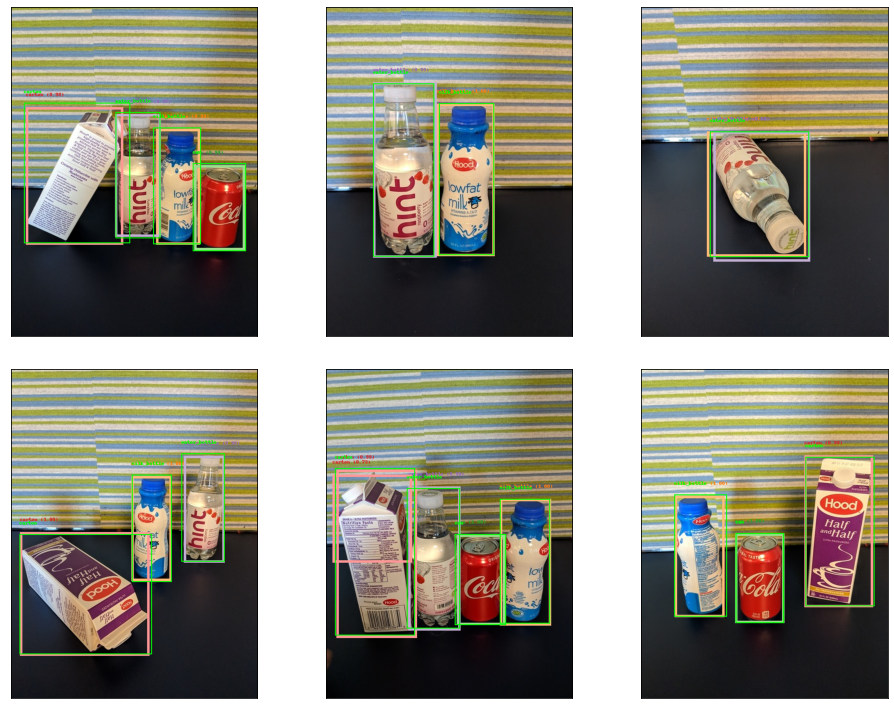

In [26]:
def _grid_helper():
    for detection in detections:
        yield detection, data, None, None
plot_grid(plot_detections, _grid_helper(), rows=2)

In [27]:
new_im_path = data.root / data.im_dir / data.im_paths[randrange(len(data))]
new_im_path

PosixPath('/content/data/odFridgeObjects/images/95.jpg')

In [28]:
detections = detector.predict(new_im_path, threshold=0.5)

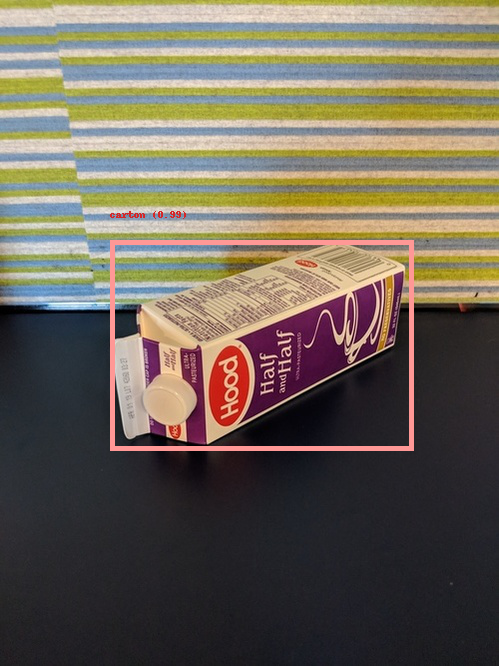

In [29]:
plot_detections(detections)

In [30]:
if SAVE_MODEL:
    detector.save("my_drink_detector")

Model is saved to /content/data/odFridgeObjects/models/my_drink_detector


In [31]:
# Preserve some of the notebook outputs
sb.glue("skip_evaluation", skip_evaluation)
sb.glue("training_losses", detector.losses)
sb.glue("training_average_precision", detector.ap)